#Introduction
16154541 -
Darren White

###Explanation of the problem
The problem presented is to use Bayesian multinomial logistic regression to classify images from the MNIST database of handwritten digits.

In [51]:
from sympy import symbols

#Dataset
The MNIST database is a set of images of handwritten digits. The database contains 60,000 training images and 10,000 testing images. The database is based on the NIST database. The NIST database was compilled from American Census Bureau employees and high school students. The training set comes from the American Census Bureau employees and the testing set has been taken from American high school students. As a result of the difference between the groups it was posited that this database may not be effiecient for machine learning.

The MNIST database is compilled as follows;

* 50% of the training data is taken from the NIST training set,
* 50% of the training data is taken from the NIST test set,
* 50% of the testing data is taken from the NIST training set, and
* 50% of the testing data is taken from the NIST test set.

The MNIST database is maintained by Yann LeCun, (Courant Institute, NYU) Corinna Cortes, (Google Labs, New York) and Christopher J.C. Burges, (Microsoft Research, Redmond).

#Method

Multinomial Logistic Regression (MLR) is used to classify the images in the MNIST database. MLR is an extension of Binary Logistic Regression (BLR). Numerous binary models are deployed simultaneuosly 

Multinomial logistic regression is used to classify categorial outcomes rather than continuous outcomes. Multinomaial models do not assume normality, linearity or homoscedasticity this makes it a strong modeling choice as real world data can often display these imperfections. 

#Code

##Imports

In [52]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [53]:
! pip install opencv-python
! pip install scikit-image
! pip install arviz

In [54]:
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline
import pymc3 as pm
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
import random
import pickle
import arviz as az
import theano as tt
import cv2
from sklearn.utils import shuffle
from skimage.color import rgb2gray
import numpy as np
from sklearn.datasets import fetch_openml

##Load Data

In [55]:
mnist = fetch_openml('mnist_784', cache=False)

In [56]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [57]:
X /= 255.0

In [58]:
X.min(), X.max()

(0.0, 1.0)

##Preprocessing

In [59]:
### Preprocess the data here. 
## Preprocessing steps could include normalization, converting to grayscale, etc.

def normalize(img):
    return cv2.normalize(img, img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    

def grayscale(img):
    #COLOR_BGR2GRAY COLOR_RGB2GRAY
    return rgb2gray(img)
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  

def setgrayscale(images):
    #from rgb to gray
    print(images.shape)
    result = np.zeros(shape=(len(images),32,32))
    for i in range(len(images)): 
        #gray = np.resize(grayscale(images[i]), (32, 32, 1))
        gray_img = grayscale(images[i])
        img_normalized = normalize(gray_img)
        result[i] = gray_img
    print(result.shape)
    return result

In [60]:
# assigning features and labels    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [61]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [62]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

In [63]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

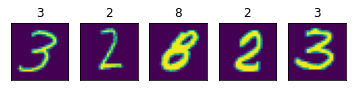

In [64]:
plot_example(X_train, y_train)

##Building a Number Classifier from the MNIST Database

A Bayesian Multinomial Logistic Regression (BMLR) is built to classify the handwritten numbers in the MNIST Database

Multinomial logistic regression is a classifiaction technique that is used to predict the category of of an input or the probability of its membership to a category. This is calculated based on multiple independent variables taht are either binary or continuous. Multinomial logistic regression allows for for the dependent variable to be part of more than two categories. https://it.unt.edu/sites/default/files/mlr_jds_aug2011.pdf

To build the classifier we must first understand its basic construction. The formula for BMLR is:

$Pr(Y_{ik} = Pr(Y_i = k\mid x_i; \beta_1 , \beta_2 , ..., \beta_m) = \frac{\displaystyle\exp(\beta_{0k} + x_i \beta_k)}{\displaystyle\sum_{j=1}^{m}\exp(\beta_{0j} + x_i\beta_j)}$ with $k = 1,2,...$

where $\beta_k$ is a row vector of regression coefficients of $x$ for the $k$th category of $y$

Since multinoomial logistic regression is an expansion of binary logistic regression we will first define a binary model.

Logistic regression assumes that for a single data point $(x,y)$:

$P(Y = 1 \mid X = x) = \sigma(z)$ where $z = \theta_0 + \displaystyle\sum_{i = 1}^{m} \theta_i x_i$

where $\theta$ is a vector of parameters of lenght $m$ the values of these parameters is found from $n$ training examples.

This is equivalent to:
$P(Y =1 \mid X = x) = \sigma(\theta^Tx)$

Maximum likelihood estimation (MLE) is used to chose the parameter values of the logistic regression. To do this we calculate the log-likelihood and find the values of $\theta$ that maximise it.

Since the predictions being made are binary we can define each label as a Bernoulli random variable. The probability of one data point can thus be written as:

$P(Y = y\mid X=x) = \sigma(\theta^Tx)^y \cdot [1 - \sigma(\theta^Tx)]^{(1-y)} $

The likelihood of all of the data is defined as follows:

The likelihood of the independent training labels:

$L(\theta) = \displaystyle\prod_{i =1}^n P(Y = y^{(i)} \mid X = x^{(i)})$

Using the likelihood of a Bernoulli we get
$L(\theta) = \displaystyle\prod_{i =1}^n P(Y = y^{(i)} \mid X = x^{(i)}) = \displaystyle\prod_{i=1}^n\sigma(\theta^Tx^{(i)})^{y^{(i)}} \cdot [1-\sigma(\theta^Tx^{(i)})]^{(1-y^{(i)})}$

Therefore the log-likelihood of the logistic regression is:

$LL(\theta) = \displaystyle\sum_{(i=1)}^ny^{(i)}\log[\sigma(\theta^Tx^{(i)}) + (1 - y^{(i)}) \log[1 - \sigma(\theta^Tx^{(i)})]$

By using a partial derivative of each parameter we can find the values of $\theta $ that maximise the log-likelihood.

The partial derivative of $LL(\theta)$ is;

$\frac{\partial LL(\theta)}{\partial\theta_j} = \displaystyle\sum_{i=1}^n [y^{(i)} - \sigma(\theta^Tx^{(i)})]x^{(i)}_j$

Using this various optimisation techniques can be deployed to identify the maximum likelihood. A typical binary logistic regression might use gradient decent, however multinomial classifiers will likely use more sophisticated techniques.

In a multinomial model 

##Classifier

###Dataset Summary

In [65]:
# Number of training examples
n_train =  len(X_train)

# Number of testing examples.
n_test = len(X_test)

#  shape of an traffic sign image
image_shape =X_train[0].shape

# unique classes/labels in the dataset.
alltotal = set(y_train )

# number of classes
n_classes = len(alltotal )

# print information
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 52500
Number of testing examples = 17500
Image data shape = (784,)
Number of classes = 10


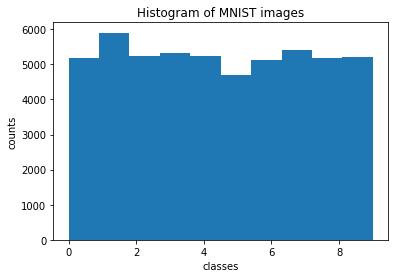

In [66]:
## plot histogram
fig, ax = plt.subplots()
# array with evenly spaced classes
ind = np.arange(n_classes)

# histogram
n, bins, patches = ax.hist(y_train, n_classes)
# horizontal axis label
ax.set_xlabel('classes')
# vertical axis label
ax.set_ylabel('counts')
# plot title
ax.set_title(r'Histogram of MNIST images')
# show plot
plt.show()

We have a relatively balanced dataset which should create good conditions for classification

###Data Preparation

In [67]:
# convert to grayscale
#X_traingray = setgrayscale(X_train)
#X_testgray = setgrayscale(X_test)

# random index
#index = random.randint(0, len(X_traingray))

#original image
#image = X_train[index]
#plt.figure(figsize=(4,4))
#plt.imshow(image)

#grayscale
#image = X_traingray[index]
#plt.figure(figsize=(4,4))
#plt.imshow(image,cmap="Greys_r")

In [68]:
np.random.seed(0)
#classes = [1, 2, 4]
classes = [3, 7, 9]
N_per_class =500

X = []
labels = []
for d in classes:
    imgs = X_train[np.where(y_train==d)[0],:]
    X.append(imgs[np.random.permutation(imgs.shape[0]),:][0:N_per_class,:])
    labels.append(np.ones(N_per_class)*d)
X_train2 = np.vstack(X).astype(np.float64)
y_train2 = np.hstack(labels)

In [69]:
print(X_train2.shape,y_train2.shape)


(1500, 784) (1500,)


In [70]:
### we split the dataset in training and validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train2, y_train2, test_size=0.2, random_state=0)
 

X_tr, y_tr = shuffle(X_tr, y_tr)

print(X_tr.shape)
print(X_val.shape)
print(y_tr.shape)
print(y_val.shape)

(1200, 784)
(300, 784)
(1200,)
(300,)


In [71]:
# transform images into vectors  
X_trv = X_tr.flatten().reshape(X_tr.shape[0],X_tr.shape[1])
X_valv = X_val.flatten().reshape(X_val.shape[0],X_tr.shape[1])
print(X_trv.shape)
print(X_valv.shape)
print(y_tr.shape)
print(y_val.shape)

(1200, 784)
(300, 784)
(1200,)
(300,)


###Algorithm

In [72]:
#General-recipe ML logistic regression
clf = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_trv, y_tr)
y_pred_logi = clf.predict(X_valv)
y_pred_logi_prob = clf.predict_proba(X_valv)
prob_classmax = np.max(y_pred_logi_prob,axis=1)
print("Accuracy=", accuracy_score(y_pred_logi,y_val))

Accuracy= 0.92


Accuracy of 0.92 is relatively good

In [73]:
np.sort(prob_classmax)

array([0.52770952, 0.53639148, 0.56985673, 0.58866785, 0.59650824,
       0.61127186, 0.62118944, 0.6364642 , 0.69931395, 0.72627642,
       0.74431025, 0.7577906 , 0.77760296, 0.78835594, 0.8138406 ,
       0.84298055, 0.86000456, 0.86140672, 0.88532692, 0.88604297,
       0.89714835, 0.92345558, 0.93176554, 0.93868643, 0.94591953,
       0.9521068 , 0.95809478, 0.96445552, 0.96975604, 0.96978435,
       0.97064007, 0.97549239, 0.97775933, 0.97776383, 0.97863492,
       0.98032797, 0.9825114 , 0.98476987, 0.98551292, 0.98729657,
       0.99088829, 0.99120109, 0.99212072, 0.99226674, 0.99235804,
       0.9939139 , 0.99500575, 0.99528383, 0.99585129, 0.99606073,
       0.99620582, 0.99623306, 0.99637545, 0.99637943, 0.99659339,
       0.99675084, 0.99678563, 0.99742742, 0.99759673, 0.99772915,
       0.99773712, 0.99826039, 0.99869139, 0.99869654, 0.99892701,
       0.99901217, 0.99910552, 0.99923696, 0.99938752, 0.99941475,
       0.99943494, 0.99945581, 0.99964387, 0.9996642 , 0.99970

In [74]:
# probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_logi!=y_val]

array([0.8138406 , 0.96978435, 0.99999838, 0.99637943, 0.58866785,
       0.72627642, 0.88532692, 0.99742742, 0.62118944, 0.99620582,
       0.96975604, 0.69931395, 0.59650824, 0.56985673, 0.99945581,
       0.99901217, 0.78835594, 0.93176554, 0.89714835, 0.77760296,
       0.99999904, 0.6364642 , 0.74431025, 0.86000456])

In [75]:
np.array(y_pred_logi)


array([3., 3., 9., 3., 9., 9., 7., 3., 3., 9., 9., 9., 9., 3., 7., 7., 9.,
       9., 3., 7., 3., 7., 3., 3., 9., 9., 7., 7., 7., 9., 9., 3., 9., 7.,
       7., 9., 3., 7., 3., 3., 9., 9., 9., 7., 3., 7., 9., 7., 7., 9., 7.,
       9., 7., 7., 7., 9., 7., 7., 9., 9., 3., 3., 9., 3., 7., 7., 9., 9.,
       3., 9., 3., 3., 7., 9., 3., 7., 7., 3., 3., 9., 9., 3., 3., 3., 7.,
       3., 9., 3., 7., 7., 7., 7., 3., 3., 9., 9., 9., 3., 3., 7., 9., 9.,
       3., 7., 9., 7., 3., 3., 7., 9., 3., 3., 3., 3., 9., 9., 3., 9., 7.,
       7., 3., 7., 3., 9., 3., 7., 3., 3., 9., 7., 7., 7., 3., 9., 7., 3.,
       3., 3., 9., 7., 3., 7., 7., 7., 3., 3., 9., 3., 9., 3., 3., 3., 9.,
       7., 7., 7., 9., 3., 7., 7., 9., 7., 3., 9., 7., 7., 7., 9., 3., 3.,
       3., 7., 9., 3., 7., 3., 3., 9., 3., 7., 7., 3., 7., 3., 7., 3., 7.,
       3., 3., 3., 3., 9., 9., 3., 9., 3., 9., 3., 3., 3., 3., 3., 7., 3.,
       7., 3., 3., 3., 7., 7., 9., 7., 3., 9., 9., 3., 9., 7., 7., 9., 7.,
       3., 7., 7., 7., 3.

###Probabilistic ML

In [76]:
import sklearn.preprocessing
## We use LabelBinarizer to transfor classes into counts
# neg_label=0, pos_label=1 
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_tr.reshape(-1,1))
nf = X_trv.shape[1]
# number of classes
nc = len(classes)
# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)


with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_trv,β1) + α1
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)

In [77]:
y_2_bin

array([[0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [78]:
with multi_logistic:
    #approx = pm.fit(300000, method='advi') # takes longer
    approx = pm.fit(3000, method='advi')

Finished [100%]: Average Loss = 8,160.4


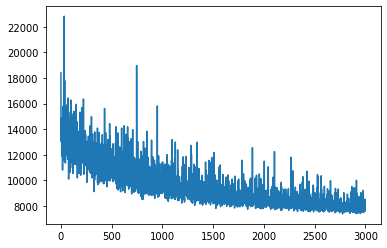

In [79]:
plt.plot(approx.hist)

In [80]:
dd = 300
posterior = approx.sample(draws=dd)

test image #10
posterior sample #100
true class= 9.0
classes: [3, 7, 9]
estimated prob= [0.00186233 0.99801402 0.00012366]


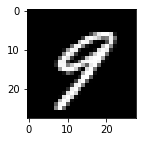

In [81]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

#select an image in the test set
i = 10 
#i = random.randint(0, dd)

#select a sample in the posterior
s = 100 
#s = random.randint(0, dd)


beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
image = X_valv[i,:].reshape(28,28)
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_valv[i,:].dot(beta) + alpha])))[0,:])

In [82]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in range(X_valv.shape[0]):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_valv[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))

In [83]:
print(y_pred_Bayesian)

[0, 0, 2, 0, 2, 2, 1, 1, 0, 2, 2, 2, 2, 0, 1, 1, 2, 2, 0, 2, 0, 1, 0, 0, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 2, 2, 0, 1, 0, 0, 2, 2, 2, 2, 0, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 0, 2, 0, 0, 1, 2, 0, 1, 1, 0, 0, 2, 2, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1, 1, 0, 0, 2, 2, 2, 0, 0, 1, 2, 2, 0, 1, 2, 1, 0, 0, 1, 2, 0, 0, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 1, 1, 1, 0, 2, 1, 0, 0, 0, 2, 1, 0, 1, 1, 1, 0, 0, 2, 0, 2, 0, 0, 2, 0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 2, 2, 1, 1, 2, 0, 0, 0, 1, 2, 0, 1, 0, 0, 2, 2, 1, 2, 0, 1, 2, 1, 0, 1, 0, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 2, 1, 0, 2, 2, 0, 2, 1, 1, 2, 1, 0, 1, 1, 0, 0, 2, 2, 0, 0, 1, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 0, 1, 2, 0, 2, 2, 0, 2, 0, 2, 1, 0, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 0, 2, 1, 0, 1, 0, 1, 1, 1, 2, 0]


In [84]:
# recall the classes we are using
print(classes)

[3, 7, 9]


In [85]:
# prediction array (using classes)
nn = 10 # just an example
np.array(classes)[y_pred_Bayesian[0:nn]]

array([3, 3, 9, 3, 9, 9, 7, 7, 3, 9])

In [86]:
# using validation: y_val
print("Accuracy=", accuracy_score(np.array(classes)[y_pred_Bayesian], y_val))

Accuracy= 0.9166666666666666


###Selecting Differences

In [87]:
y_predB=[]

for i in range(X_valv.shape[0]):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_valv[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

In [88]:
# prediction array
mm = 10
y_predB[0:mm,:]

array([[0.        , 0.95239461, 0.20360637],
       [0.        , 0.99206684, 0.08137704],
       [2.        , 0.9837546 , 0.08137704],
       [0.        , 0.99483269, 0.08137704],
       [2.        , 0.99772295, 0.05763872],
       [2.        , 0.71749458, 0.44899889],
       [1.        , 0.89956703, 0.28134597],
       [1.        , 0.56179316, 0.49638695],
       [0.        , 0.99654732, 0.05763872],
       [2.        , 0.99956976, 0.        ]])

In [89]:
#sorting in descending order
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[1.        , 0.48889336, 0.5       ],
       [1.        , 0.49047055, 0.49995555],
       [1.        , 0.49024782, 0.49995555],
       [1.        , 0.51152751, 0.49982219],
       [2.        , 0.46279858, 0.49945526],
       [1.        , 0.4748066 , 0.49928838],
       [1.        , 0.5151659 , 0.49909919],
       [0.        , 0.50043343, 0.49888765],
       [1.        , 0.45411123, 0.49839743],
       [0.        , 0.54500296, 0.49839743]])

In [90]:
#probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_logi != y_val]

array([0.8138406 , 0.96978435, 0.99999838, 0.99637943, 0.58866785,
       0.72627642, 0.88532692, 0.99742742, 0.62118944, 0.99620582,
       0.96975604, 0.69931395, 0.59650824, 0.56985673, 0.99945581,
       0.99901217, 0.78835594, 0.93176554, 0.89714835, 0.77760296,
       0.99999904, 0.6364642 , 0.74431025, 0.86000456])

In [91]:
y_predB[y_pred_logi != y_val,:]

array([[2.        , 0.75182731, 0.42909465],
       [2.        , 0.83637674, 0.36660606],
       [1.        , 0.4748066 , 0.49928838],
       [2.        , 0.99997583, 0.        ],
       [2.        , 0.97756475, 0.11469767],
       [2.        , 0.80783736, 0.38418745],
       [0.        , 0.92540366, 0.24944383],
       [2.        , 0.83940888, 0.35377331],
       [1.        , 0.5151659 , 0.49909919],
       [2.        , 0.86430144, 0.30868898],
       [2.        , 0.69284393, 0.46110977],
       [2.        , 0.74368623, 0.43492017],
       [0.        , 0.86810904, 0.32496154],
       [2.        , 0.56199036, 0.49243161],
       [1.        , 0.64856529, 0.47370877],
       [2.        , 0.7706614 , 0.40730824],
       [2.        , 0.66561914, 0.46110977],
       [2.        , 0.5366791 , 0.49714742],
       [0.        , 0.72406061, 0.44735022],
       [2.        , 0.77433975, 0.40966111],
       [1.        , 0.99007706, 0.05763872],
       [2.        , 0.84343547, 0.35041246],
       [0.

In [92]:
## Difficult & easy instances

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_logi[easy[0:100]], y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_logi[difficult[0:100]], y_val[difficult[0:100]]))

Accuracy in easy instances = 0.97
Accuracy in difficult instances = 0.83


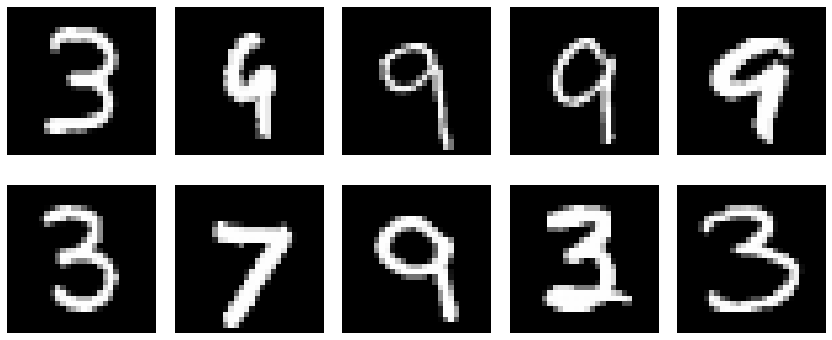

In [93]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_valv[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

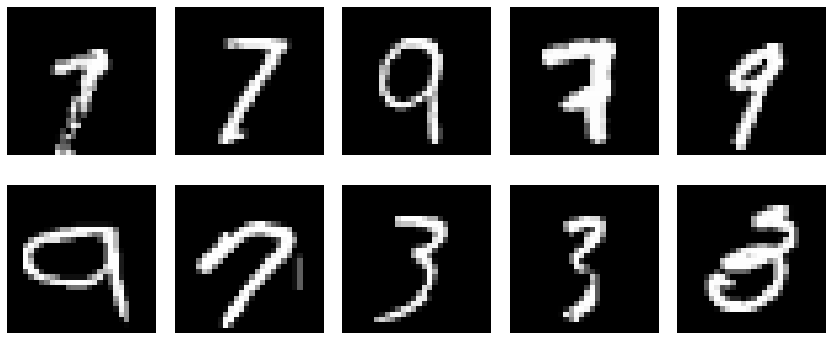

In [94]:
# show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    image = X_valv[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

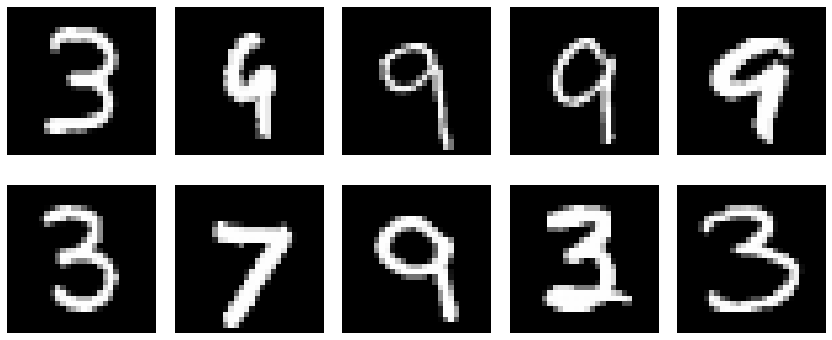

In [95]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_valv[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

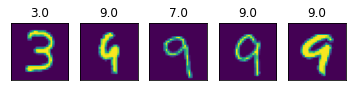

In [96]:
plot_example(X_valv[easy],y_pred_logi[easy])

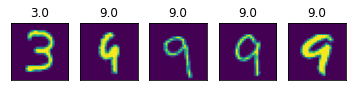

In [97]:
plot_example(X_valv[easy],y_val[easy])

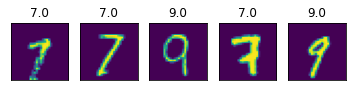

In [98]:
plot_example(X_valv[difficult],y_pred_logi[difficult] )

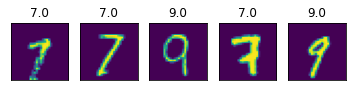

In [99]:
plot_example(X_valv[difficult],y_val[difficult] )

#Summary

#References